In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#seaborn color palette
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv('PJMW_hourly.csv')

#dataset begins with Datetime column
df =df.set_index('Datetime')

## change the dtype of the datetime column

df.index = pd.to_datetime(df.index)

In [3]:
#view the data
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [4]:
#check the column dtype
df.dtypes

PJMW_MW    float64
dtype: object

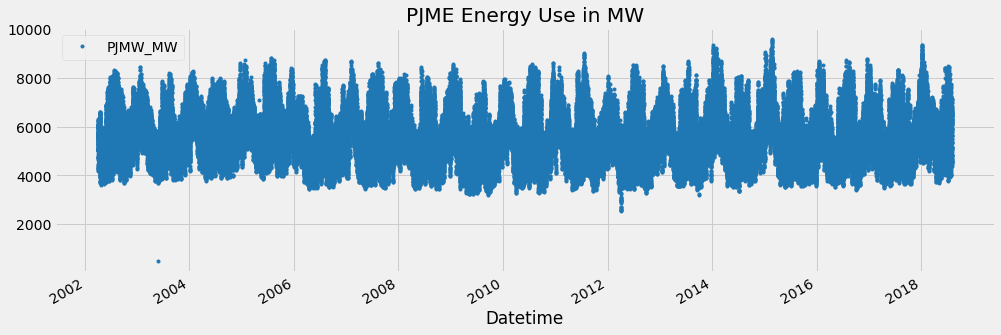

In [5]:
## Plotting the dataset

df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0], 
        title='PJMW Energy Use in MW')
plt.show()

## Train / Split Data

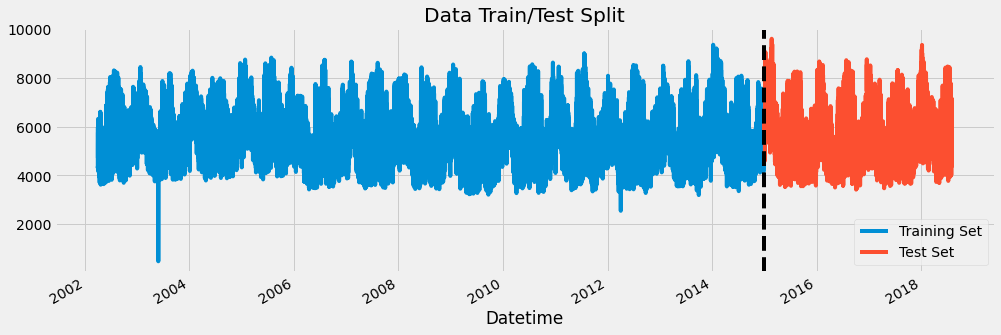

In [6]:
#Splitting the data by  </>= '01-01-2015'
train = df.loc[df.index <'01-01-2015']
test = df.loc[df.index >= '01-01-2015']

#Plot the data in a graph
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label='Training Set',title='Data Train/Test Split')
test.plot(ax=ax,label = 'Test Set')
ax.axvline('01-01-2015',color='black',ls='--') # Plot split line 
ax.legend(['Training Set','Test Set'])
plt.show()

## Feature Creation

In [7]:
### Splitting the date and time into multiple sections ###
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

df.tail()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2018-01-01 20:00:00,8401.0,20,0,1,1,2018,1
2018-01-01 21:00:00,8373.0,21,0,1,1,2018,1
2018-01-01 22:00:00,8238.0,22,0,1,1,2018,1
2018-01-01 23:00:00,7958.0,23,0,1,1,2018,1
2018-01-02 00:00:00,7691.0,0,1,1,1,2018,2


## Visualize the Features and Target Variable

Text(0.5, 1.0, 'MW by Month')

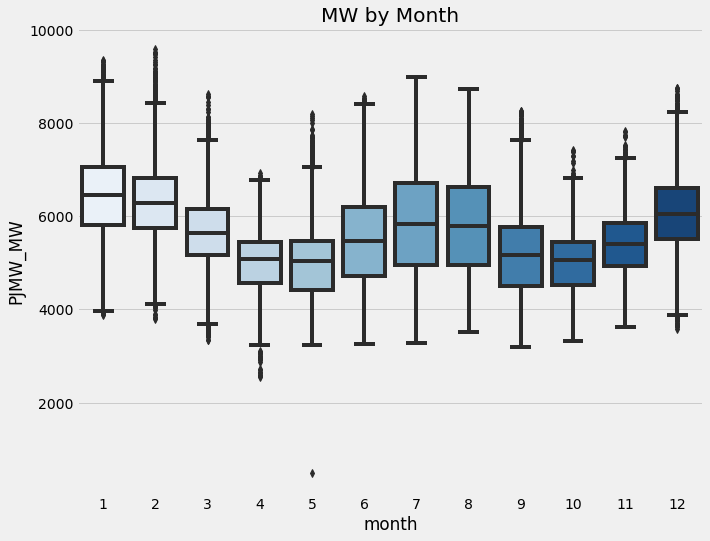

In [8]:
#Plot the data in a graph
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data=df, x='month', y='PJMW_MW',palette='Blues')
ax.set_title('MW by Month')

## Create a model

In [9]:
#### Get the training and test data through the newly created features function
train = create_features(train)
test = create_features(test)

In [10]:
#using columns instance to get the columns of the dataset
df.columns

Index(['PJMW_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [11]:
### Seperate features and target columns

Features = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
Target = 'PJMW_MW'

In [12]:
### Seperating both features and target variables in both train and test sets
x_train = train[Features]
y_train = train[Target]

x_test = test[Features]
y_test = test[Target]

In [32]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate =0.01)  ## 1000 trees and early stopping when if the train set does not improved
reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
        verbose=100) #Fitting training data to the model

[15:58:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5625.61298	validation_1-rmse:5649.37183
[100]	validation_0-rmse:2153.53276	validation_1-rmse:2187.28575
[200]	validation_0-rmse:973.14194	validation_1-rmse:1047.32551
[300]	validation_0-rmse:639.71263	validation_1-rmse:752.64583
[400]	validation_0-rmse:554.43183	validation_1-rmse:683.87518
[500]	validation_0-rmse:526.71056	validation_1-rmse:666.56990
[600]	validation_0-rmse:511.41625	validation_1-rmse:660.94958
[700]	validation_0-rmse:501.27330	validation_1-rmse:658.64564
[784]	validation_0-rmse:495.01717	validation_1-rmse:658.54032


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

#### Above Case, situation will get worse after [489] itarations 

## Feature Importance

In [14]:
# Feature importance based on the each of the trees built by xgboost model
reg.feature_importances_

array([0.39722762, 0.13936946, 0.16839816, 0.13659972, 0.04438392,
       0.11402117], dtype=float32)

In [15]:
fi = pd.DataFrame(data =reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

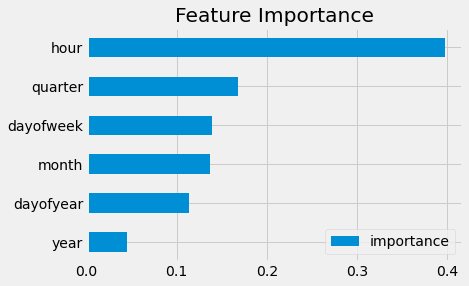

In [16]:
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

# Forcast on the test

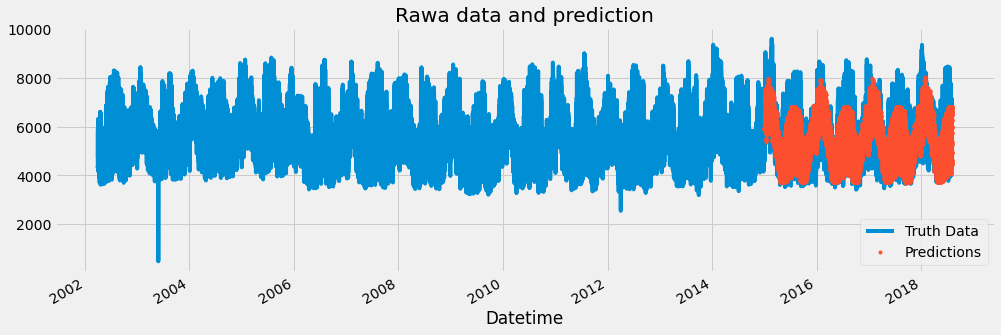

In [17]:
## Taking the test set and creating a column called prediction to save the prediction data
test['prediction'] = reg.predict(x_test)
## at the end merging the sets together
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)
ax = df[['PJMW_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Rawa data and prediction')
plt.show()

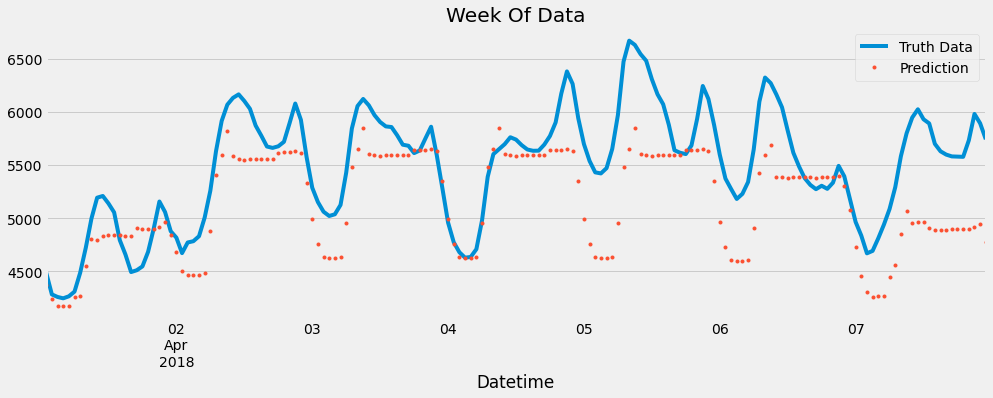

In [33]:
### Actual VS Prediction

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJMW_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [18]:
df

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-04-01 01:00:00,4374.0,1,0,2,4,2002,91,NaN
2002-04-01 02:00:00,4306.0,2,0,2,4,2002,91,NaN
2002-04-01 03:00:00,4322.0,3,0,2,4,2002,91,NaN
2002-04-01 04:00:00,4359.0,4,0,2,4,2002,91,NaN
2002-04-01 05:00:00,4436.0,5,0,2,4,2002,91,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,20,3,3,8,2018,214,6614.498047
2018-08-02 21:00:00,6496.0,21,3,3,8,2018,214,6612.229492
2018-08-02 22:00:00,6325.0,22,3,3,8,2018,214,6497.265137


In [36]:
## Calculate mean squared error (RMSE)
score = np.sqrt(mean_squared_error(test['PJMW_MW'], test['prediction']))
score

648.8359000424666

In [47]:
## Calculate error
test['error'] = np.abs(test['PJMW_MW'] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)


date
2018-01-06    2306.101847
2015-02-20    2171.773010
2015-02-15    2104.082926
2017-12-31    2082.776672
2015-02-16    2035.435649
2015-02-19    1974.757833
2018-01-07    1952.096965
2015-02-21    1905.153015
2018-01-05    1831.022380
2017-12-28    1784.914917
Name: error, dtype: float64

In [48]:
test

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,date,error
Datetime,,,,,,,,,,
2015-01-01 00:00:00,6365.0,0,3,1,1,2015,1,6054.336426,2015-01-01,310.663574
2015-12-31 01:00:00,4530.0,1,3,4,12,2015,365,5350.058105,2015-12-31,820.058105
2015-12-31 02:00:00,4383.0,2,3,4,12,2015,365,5266.933105,2015-12-31,883.933105
2015-12-31 03:00:00,4299.0,3,3,4,12,2015,365,5250.099609,2015-12-31,951.099609
2015-12-31 04:00:00,4338.0,4,3,4,12,2015,365,5250.099609,2015-12-31,912.099609
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,8401.0,20,0,1,1,2018,1,6593.192871,2018-01-01,1807.807129
2018-01-01 21:00:00,8373.0,21,0,1,1,2018,1,6593.192871,2018-01-01,1779.807129
2018-01-01 22:00:00,8238.0,22,0,1,1,2018,1,6471.185547,2018-01-01,1766.814453
